In [57]:
import json
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from transformers import pipeline
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.metrics import precision_score, recall_score
import json
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import json
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from collections import Counter


%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [59]:
# Step 1: Load the data from JSON
with open('prompt1_FEW.json', 'r') as json_file:
    data = json.load(json_file)

In [60]:
# Initialize lists to store existing and generated texts
existing_texts = []
generated_texts = []

In [61]:
# Step 2: Define Evaluation Metrics
bleu_scores = []
x_labels = []
for entry in data:
    reference = entry['existing_text']
    generated = entry['generated_text1']
    reference_tokens = nltk.word_tokenize(reference.lower())
    generated_tokens = nltk.word_tokenize(generated.lower())
    bleu_score = sentence_bleu([reference_tokens], generated_tokens)
    bleu_scores.append(bleu_score)
    x_labels.append(f"Author {len(x_labels) + 1}")

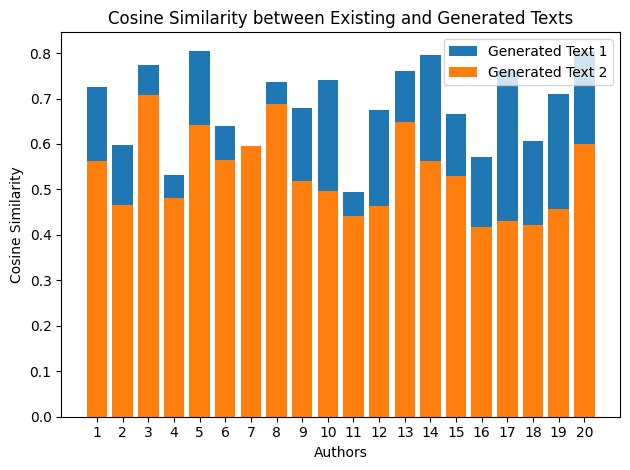

In [57]:
# Custom tokenizer that splits on whitespace
def tokenizer(text):
    return text.split()

# List to store cosine similarity scores
cosine_sims_existing = []
cosine_sims_generated1 = []
cosine_sims_generated2 = []

# Iterate over each entry in the JSON data
for i, entry in enumerate(data):
    existing_text = entry['existing_text']
    generated_text1 = entry['generated_text1']
    generated_text2 = entry['generated_text2']

    # Remove empty documents
    existing_text = existing_text.strip()
    generated_text1 = generated_text1.strip()
    generated_text2 = generated_text2.strip()

    # Create TfidfVectorizer object with custom tokenizer
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english')

    # Fit and transform the existing and generated texts
    tfidf_existing = vectorizer.fit_transform([existing_text])
    tfidf_generated1 = vectorizer.transform([generated_text1])
    tfidf_generated2 = vectorizer.transform([generated_text2])

    # Calculate the cosine similarity
    cosine_sim_existing = cosine_similarity(tfidf_existing, tfidf_generated1)
    cosine_sim_generated1 = cosine_similarity(tfidf_existing, tfidf_generated2)

    cosine_sims_existing.append(cosine_sim_existing[0][0])
    cosine_sims_generated1.append(cosine_sim_generated1[0][0])

# Plot the cosine similarity scores
x_values = range(1, len(data) + 1)
plt.bar(x_values, cosine_sims_existing, label='Generated Text 1')
plt.bar(x_values, cosine_sims_generated1, label='Generated Text 2')
plt.xlabel('Authors')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Existing and Generated Texts')
plt.xticks(x_values)
plt.legend()
plt.tight_layout()
plt.show()


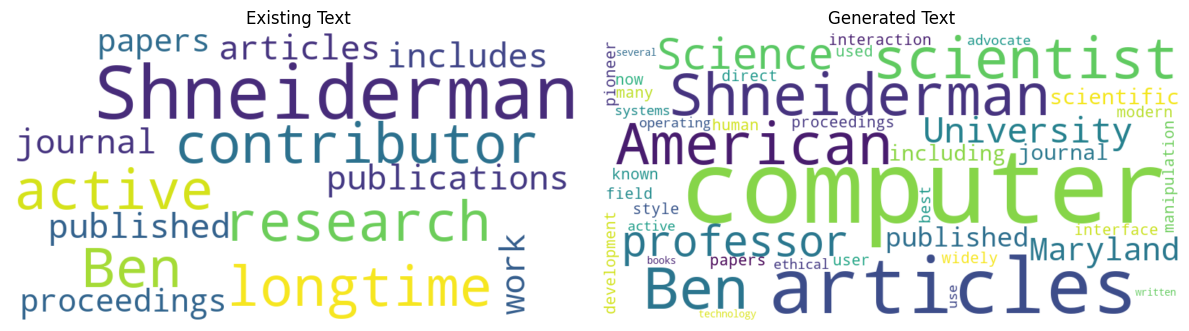

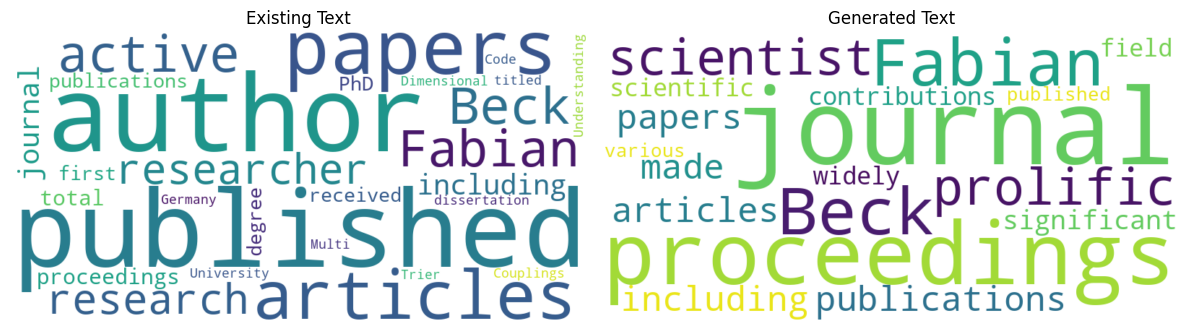

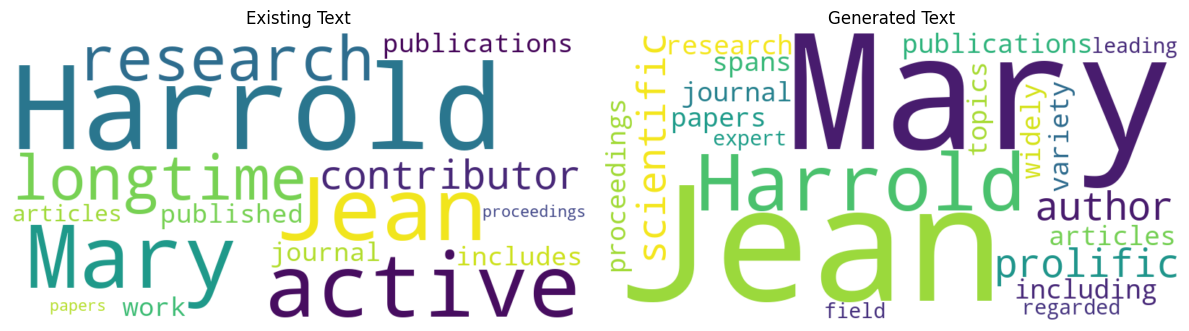

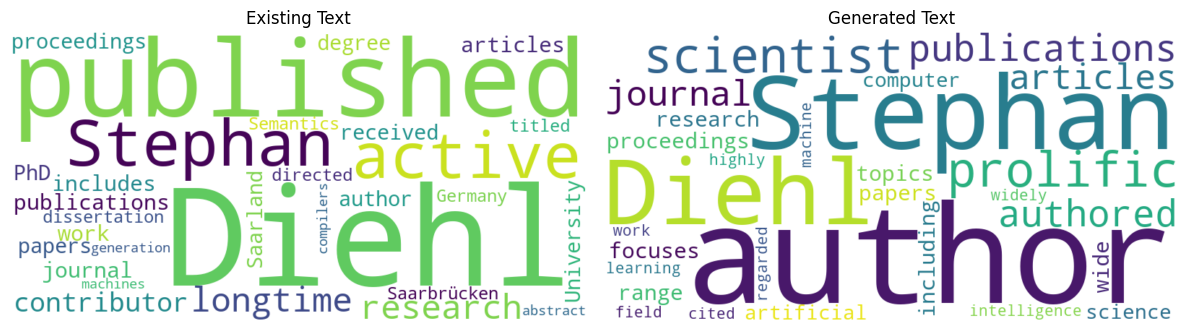

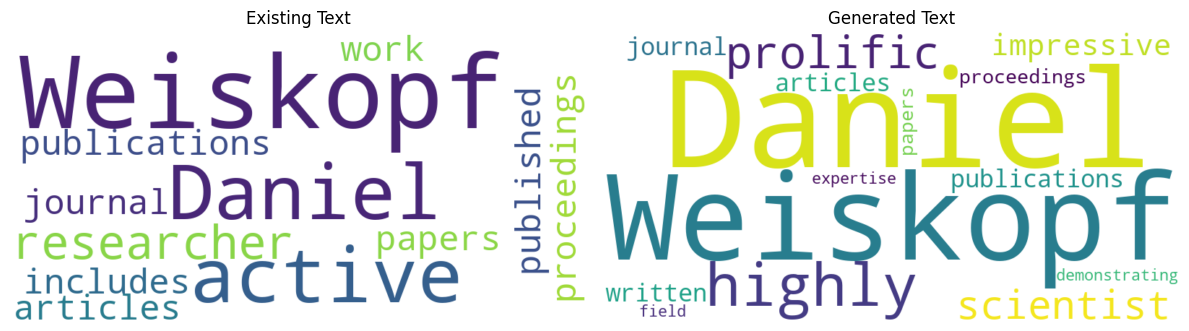

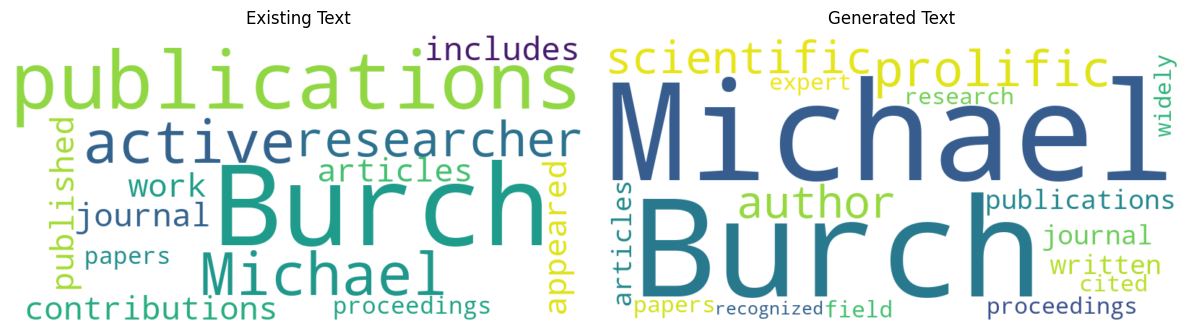

In [11]:


# Extract the existing and generated texts from the JSON data
for entry in data:
    existing_texts.append(entry['existing_text'])
    generated_texts.append(entry['generated_text1'])

# Generate word clouds for each pair of texts
for i in range(len(existing_texts)):
    existing_text = existing_texts[i]
    generated_text = generated_texts[i]

    # Generate word cloud for the existing text
    existing_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(existing_text)

    # Generate word cloud for the generated text
    generated_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(generated_text)

    # Plot the word clouds
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(existing_wordcloud, interpolation='bilinear')
    axes[0].set_title('Existing Text')
    axes[0].axis('off')

    axes[1].imshow(generated_wordcloud, interpolation='bilinear')
    axes[1].set_title('Generated Text')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


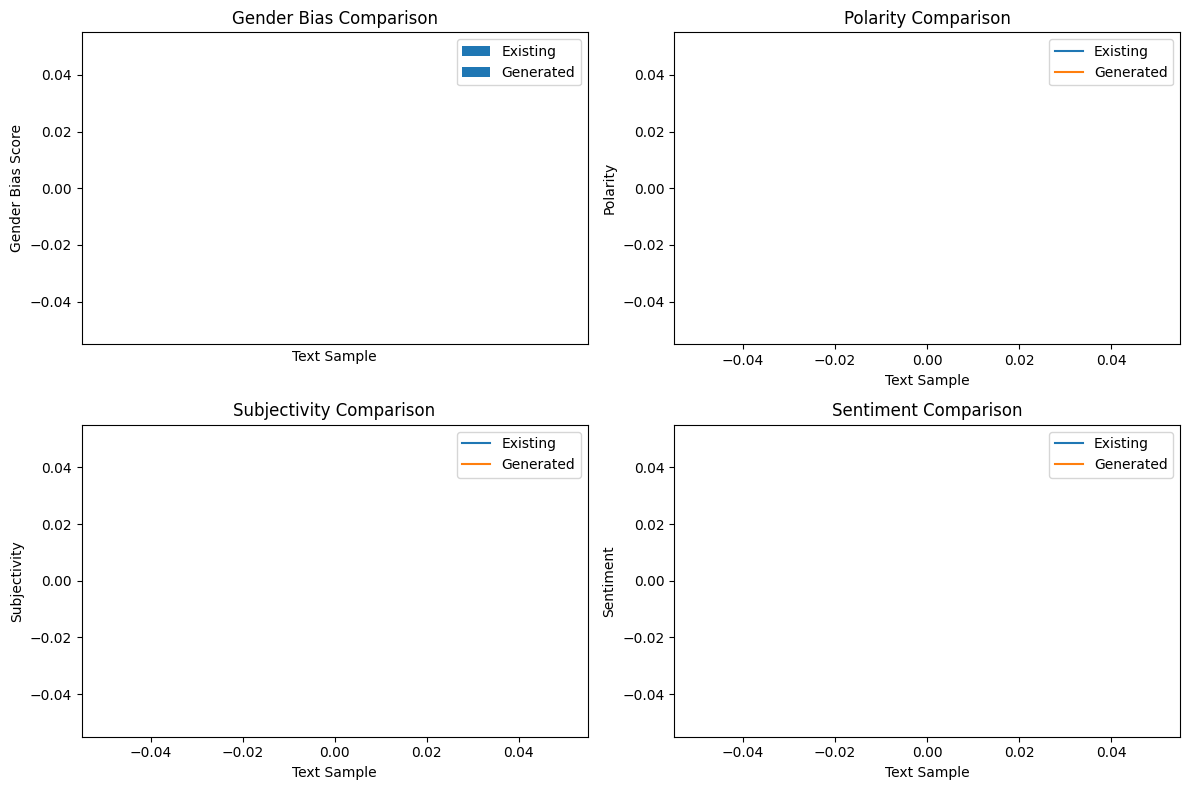

In [19]:

# Step 2: Perform Gender Bias Detection
def detect_gender_bias(text):
    # Load the gender bias detection model (e.g., BERT or GPT-3) and tokenize the input
    model = pipeline('text-classification', model='bert-base-uncased')
    result = model(text)[0]  # Assuming single-text classification
    label = result['label']
    score = result['score']
    return label, score

existing_gender_bias = [detect_gender_bias(text) for text in existing_texts]
generated_gender_bias = [detect_gender_bias(text) for text in generated_texts]

# Step 3: Perform Tone Detection
def detect_tone(text):
    # Using TextBlob
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    # Using VaderSentiment
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)

    return polarity, subjectivity, sentiment

existing_tones = [detect_tone(text) for text in existing_texts]
generated_tones = [detect_tone(text) for text in generated_texts]

# Step 4: Visualize the Metrics
existing_polarity = [tone[0] for tone in existing_tones]
generated_polarity = [tone[0] for tone in generated_tones]

existing_subjectivity = [tone[1] for tone in existing_tones]
generated_subjectivity = [tone[1] for tone in generated_tones]

existing_sentiment = [tone[2]['compound'] for tone in existing_tones]
generated_sentiment = [tone[2]['compound'] for tone in generated_tones]

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Gender Bias
axes[0, 0].bar(range(len(existing_gender_bias)), [score for _, score in existing_gender_bias], label='Existing')
axes[0, 0].bar(range(len(generated_gender_bias)), [score for _, score in generated_gender_bias], label='Generated')
axes[0, 0].set_xticks(range(len(existing_gender_bias)))
axes[0, 0].set_xticklabels(range(1, len(existing_gender_bias) + 1))
axes[0, 0].set_xlabel('Text Sample')
axes[0, 0].set_ylabel('Gender Bias Score')
axes[0, 0].set_title('Gender Bias Comparison')
axes[0, 0].legend()

# Polarity
axes[0, 1].plot(existing_polarity, label='Existing')
axes[0, 1].plot(generated_polarity, label='Generated')
axes[0, 1].set_xlabel('Text Sample')
axes[0, 1].set_ylabel('Polarity')
axes[0, 1].set_title('Polarity Comparison')
axes[0, 1].legend()

# Subjectivity
axes[1, 0].plot(existing_subjectivity, label='Existing')
axes[1, 0].plot(generated_subjectivity, label='Generated')
axes[1, 0].set_xlabel('Text Sample')
axes[1, 0].set_ylabel('Subjectivity')
axes[1, 0].set_title('Subjectivity Comparison')
axes[1, 0].legend()

# Sentiment
axes[1, 1].plot(existing_sentiment, label='Existing')
axes[1, 1].plot(generated_sentiment, label='Generated')
axes[1, 1].set_xlabel('Text Sample')
axes[1, 1].set_ylabel('Sentiment')
axes[1, 1].set_title('Sentiment Comparison')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


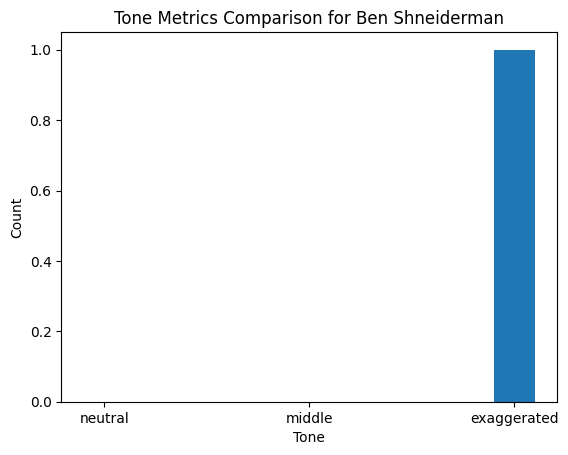

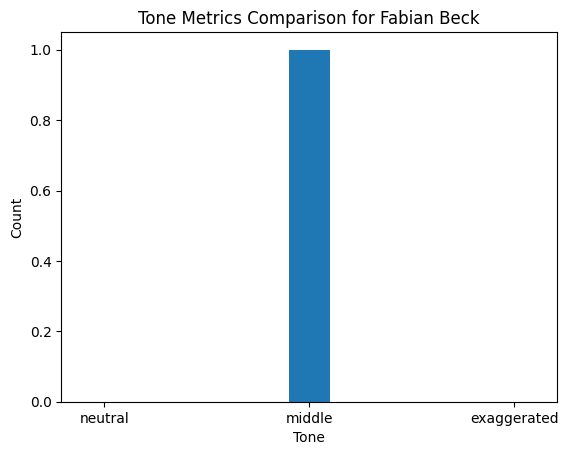

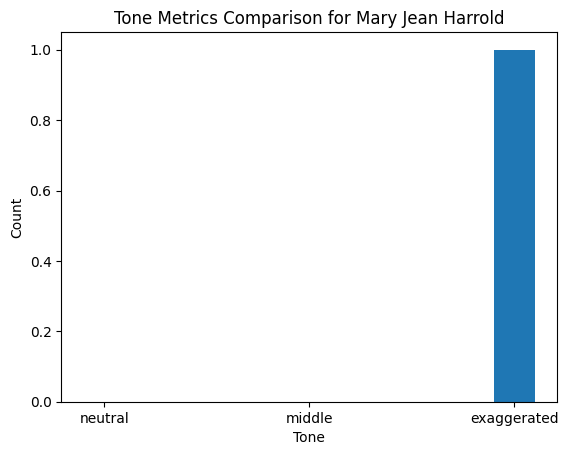

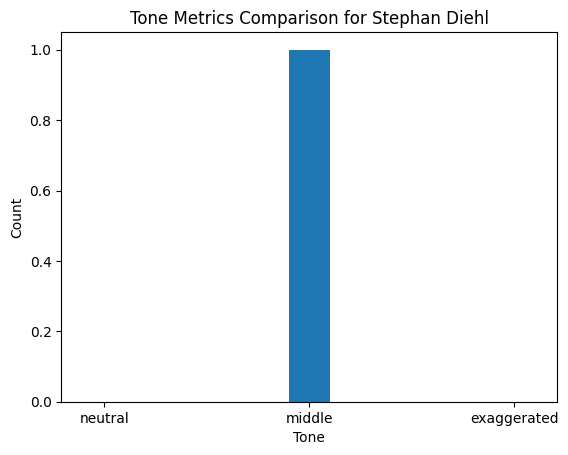

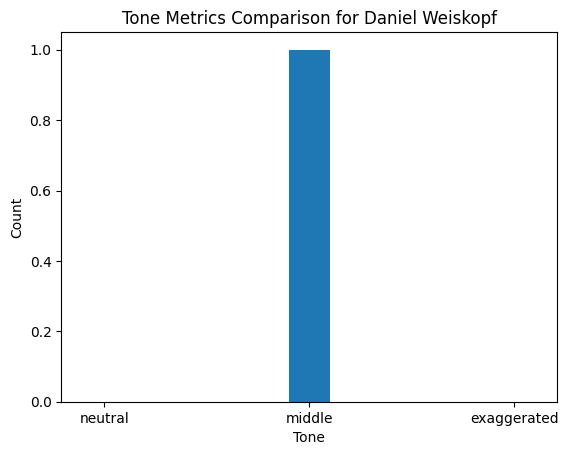

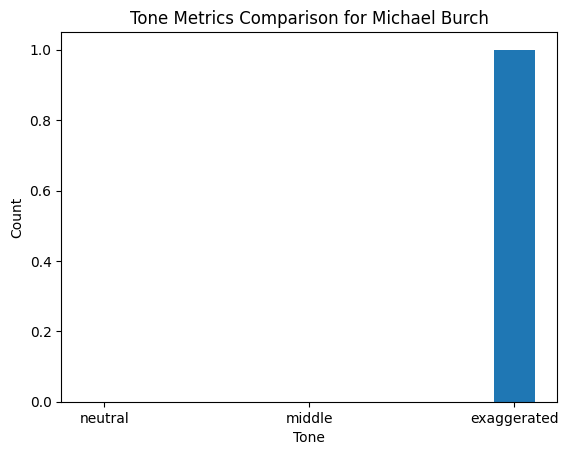

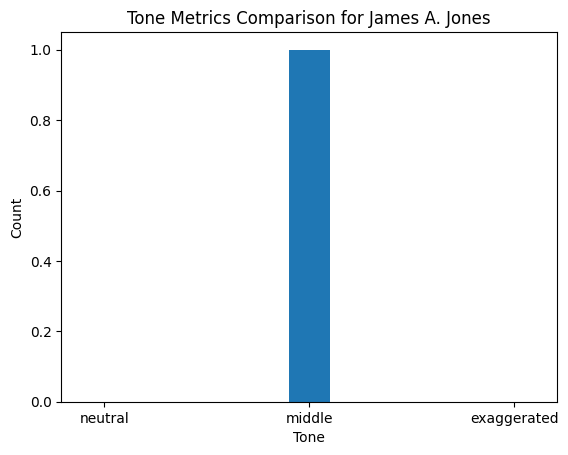

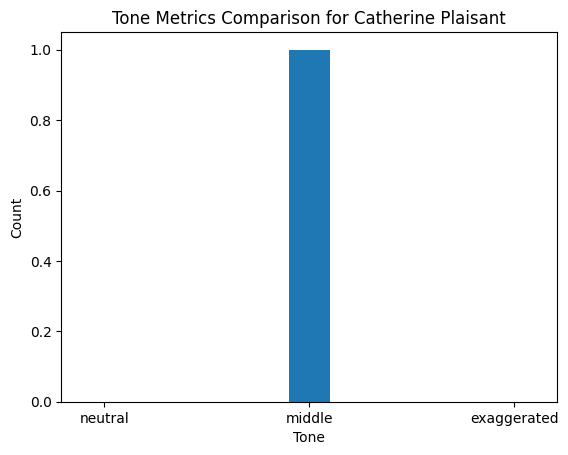

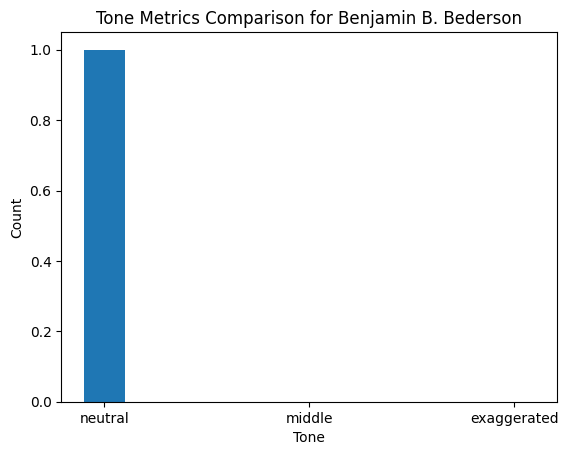

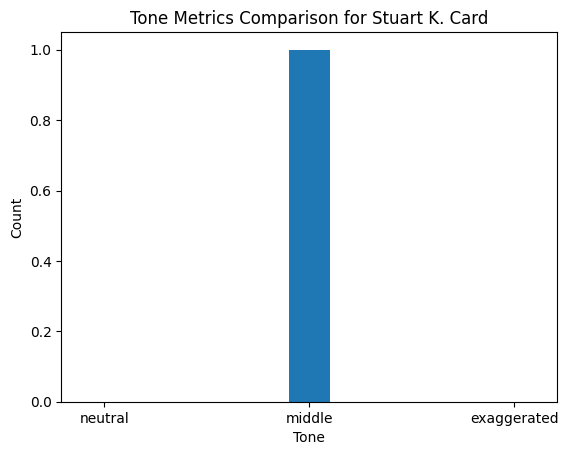

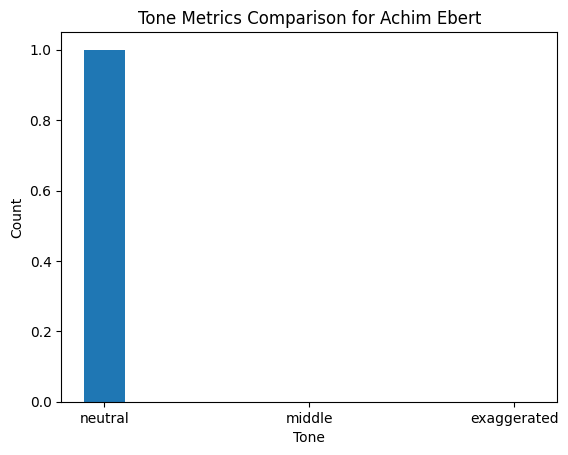

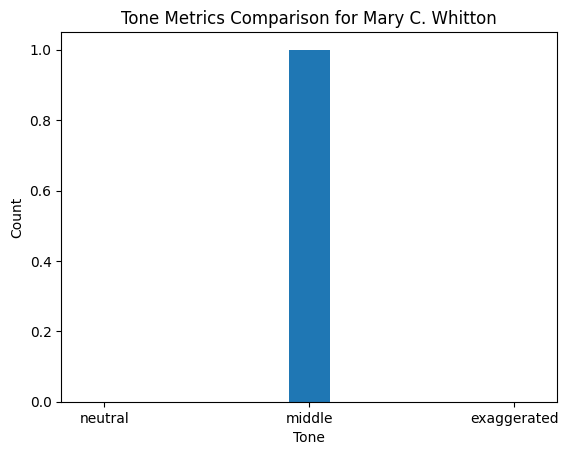

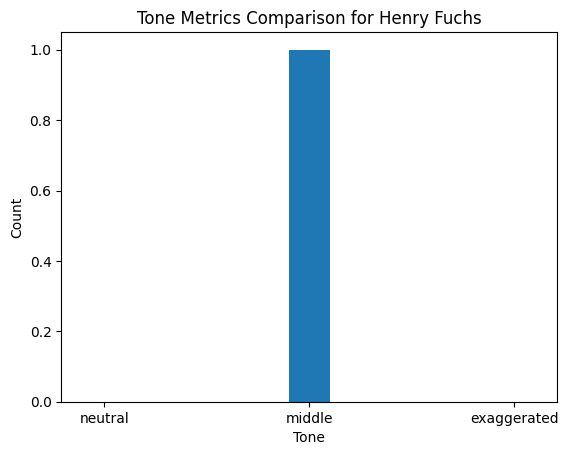

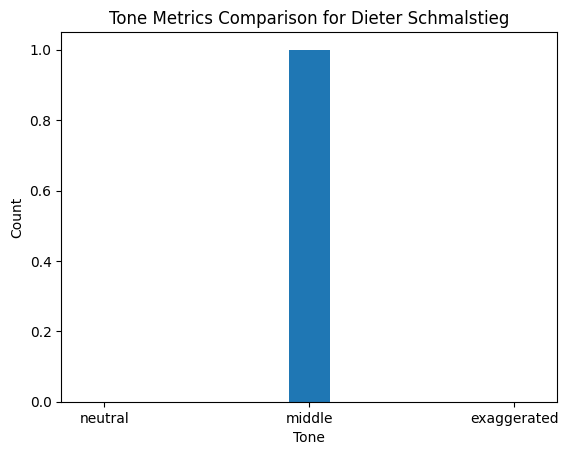

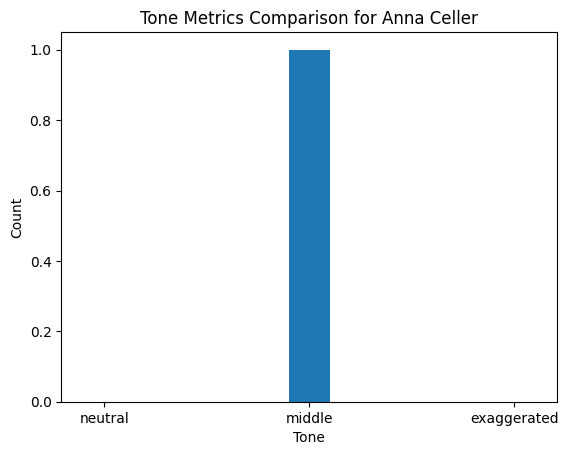

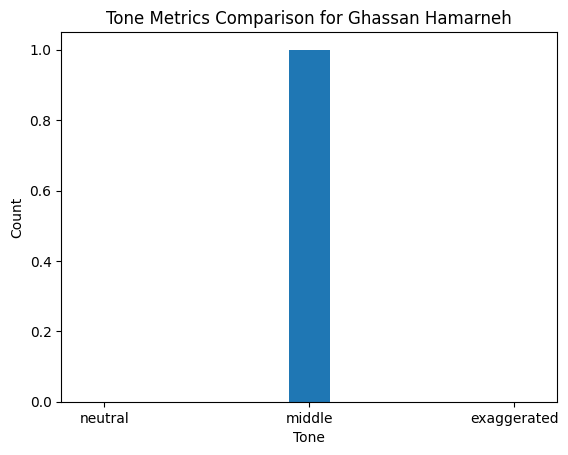

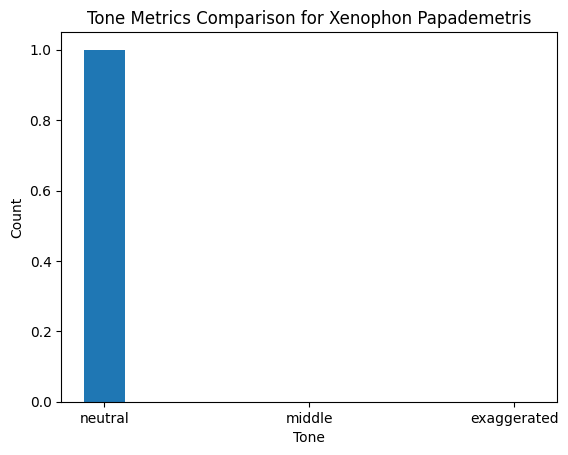

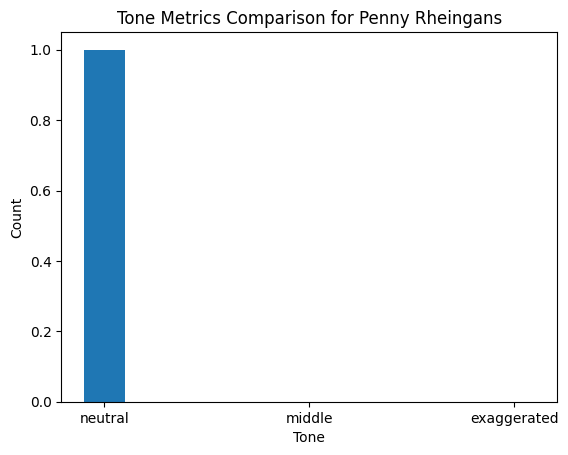

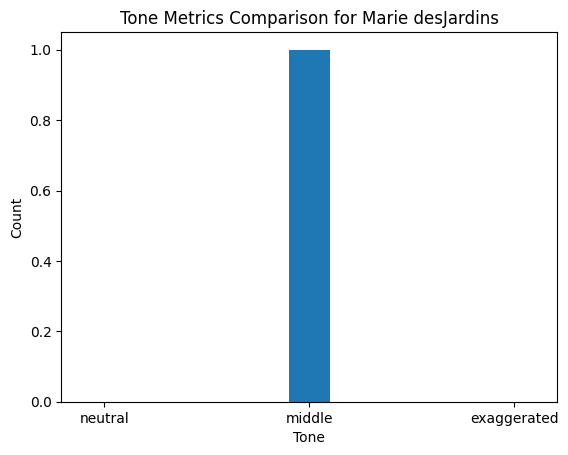

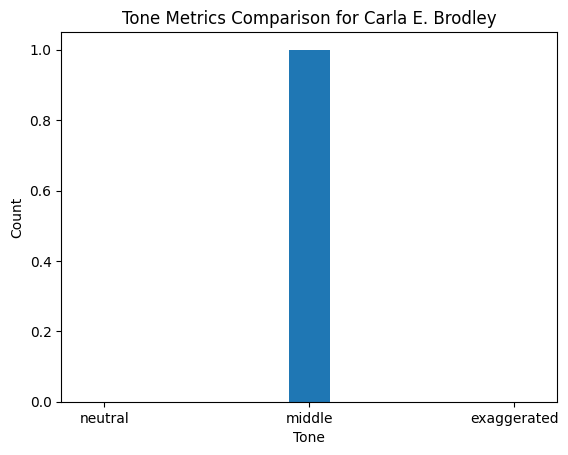

In [20]:


entry_names = [entry['name'] for entry in data]
existing_texts = [entry['existing_text'] for entry in data]
generated_texts = [entry['generated_text1'] for entry in data]

# Step 2: Define Tone Ranges
tone_ranges = {
    'neutral': (0.0, 0.2),
    'middle': (0.2, 0.4),
    'exaggerated': (0.4, 1.0)
}

# Step 3: Calculate Tone Metric for Each Entry
tone_metrics = []
for existing_text, generated_text in zip(existing_texts, generated_texts):
    existing_blob = TextBlob(existing_text)
    generated_blob = TextBlob(generated_text)

    existing_polarity = existing_blob.sentiment.polarity
    generated_polarity = generated_blob.sentiment.polarity

    tone_metric = None
    for tone, (lower, upper) in tone_ranges.items():
        if existing_polarity >= lower and existing_polarity < upper:
            tone_metric = tone
            break

    if generated_polarity >= upper:
        tone_metric = 'exaggerated'
    elif generated_polarity >= lower:
        tone_metric = 'middle'
    elif generated_polarity < lower:
        tone_metric = 'neutral'

    tone_metrics.append(tone_metric)

# Step 4: Count Tone Metrics for Each Entry
unique_tones = list(tone_ranges.keys())
counts_per_entry = []

for entry in entry_names:
    entry_counts = [tone_metrics[i] for i in range(len(entry_names)) if entry_names[i] == entry]
    counts = [entry_counts.count(tone) for tone in unique_tones]
    counts_per_entry.append(counts)

# Step 5: Visualize the Tone Metrics
bar_width = 0.2
index = np.arange(len(unique_tones))

for i, entry in enumerate(entry_names):
    fig, ax = plt.subplots()
    ax.bar(index, counts_per_entry[i], bar_width)
    ax.set_xlabel('Tone')
    ax.set_ylabel('Count')
    ax.set_title(f'Tone Metrics Comparison for {entry}')
    ax.set_xticks(index)
    ax.set_xticklabels(unique_tones)
    plt.show()


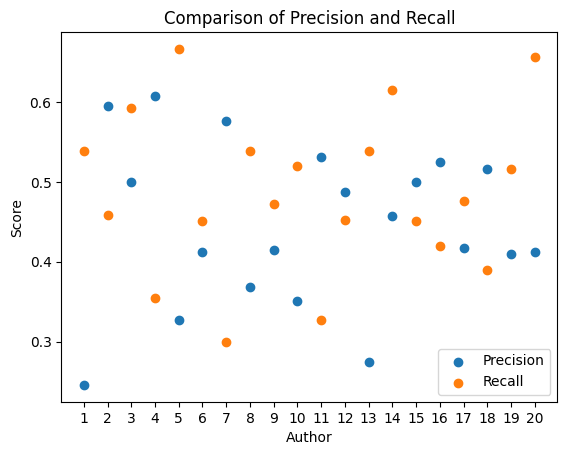

In [24]:


existing_texts = [entry['existing_text'] for entry in data]
generated_texts = [entry['generated_text1'] for entry in data]

# Step 2: Calculate Precision and Recall
precisions = []
recalls = []

for existing_text, generated_text in zip(existing_texts, generated_texts):
    # Convert the texts to sets of words for comparison
    existing_set = set(existing_text.lower().split())
    generated_set = set(generated_text.lower().split())
    
    # Calculate precision and recall
    # A higher precision score indicates that the generated text contains a higher proportion of relevant information from the existing text.
    # Recall measures the proportion of relevant items that are correctly identified. 
    # In the context of comparing existing text and generated text, recall represents the coverage or inclusiveness of the generated text.
    # A higher recall score indicates that the generated text captures a higher proportion of relevant information from the existing text
    precision = len(existing_set.intersection(generated_set)) / len(generated_set)
    recall = len(existing_set.intersection(generated_set)) / len(existing_set)
    
    precisions.append(precision)
    recalls.append(recall)

# Step 3: Visualize Precision and Recall
entry_labels = [f"{i+1}" for i in range(len(data))]

x = range(len(data))
plt.scatter(x, precisions, label='Precision')
plt.scatter(x, recalls, label='Recall')

plt.xlabel('Author')
plt.ylabel('Score')
plt.title('Comparison of Precision and Recall')
plt.xticks(x, entry_labels)
plt.legend()
plt.show()


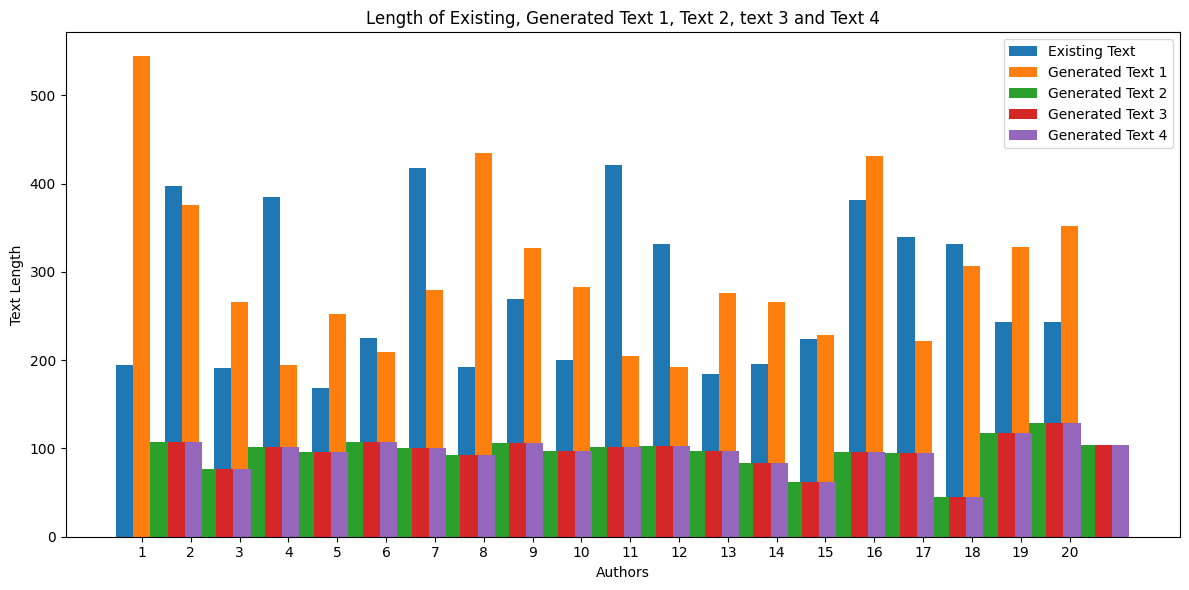

In [30]:


# Initialize lists to store text lengths
existing_lengths = []
generated_lengths = []
generated2_lengths = []
generated3_lengths = []
generated4_lengths = []

# Iterate over each entry in the JSON data
for i, entry in enumerate(data):
    existing_text = entry['existing_text']
    generated_text = entry['generated_text1']
    generated2_text = entry['generated_text2']
    generated3_text = entry['generated_text3']
    generated4_text = entry['generated_text4']

    # Get the lengths of existing, generated, and generated2 texts
    existing_length = len(existing_text)
    generated_length = len(generated_text)
    generated2_length = len(generated2_text)
    generated3_length = len(generated3_text)
    generated4_length = len(generated4_text)

    # Append text lengths to respective lists
    existing_lengths.append(existing_length)
    generated_lengths.append(generated_length)
    generated2_lengths.append(generated2_length)
    generated3_lengths.append(generated3_length)
    generated4_lengths.append(generated4_length)

# Set up the bar chart
x = range(len(data))
width = 0.35
plt.figure(figsize=(12, 6))

# Plot the lengths of existing, generated, and generated2 texts
plt.bar(x, existing_lengths, width, label='Existing Text')
plt.bar([val + width for val in x], generated_lengths, width, label='Generated Text 1')
plt.bar([val + width*2 for val in x], generated2_lengths, width, label='Generated Text 2')
plt.bar([val + width*3 for val in x], generated2_lengths, width, label='Generated Text 3')
plt.bar([val + width*4 for val in x], generated2_lengths, width, label='Generated Text 4')

# Set the labels and title
plt.xlabel('Authors')
plt.ylabel('Text Length')
plt.title('Length of Existing, Generated Text 1, Text 2, text 3 and Text 4')

# Set the x-axis tick labels as entry numbers
plt.xticks([val + width for val in x], range(1, len(data) + 1))

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


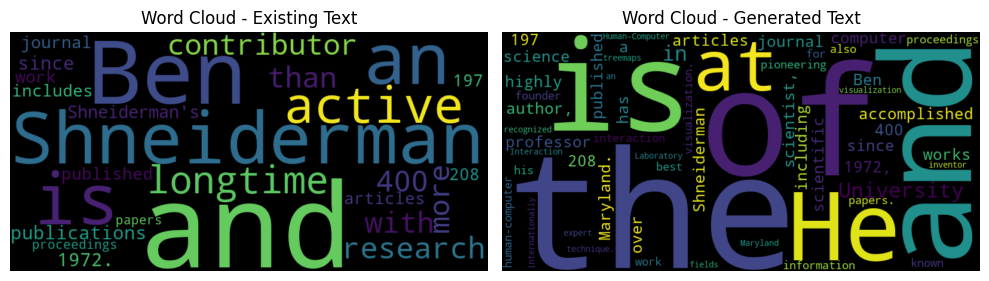

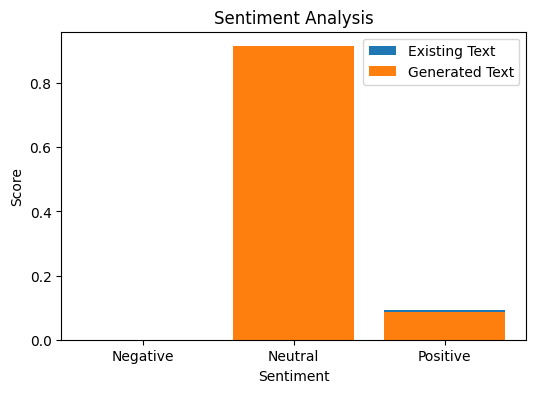

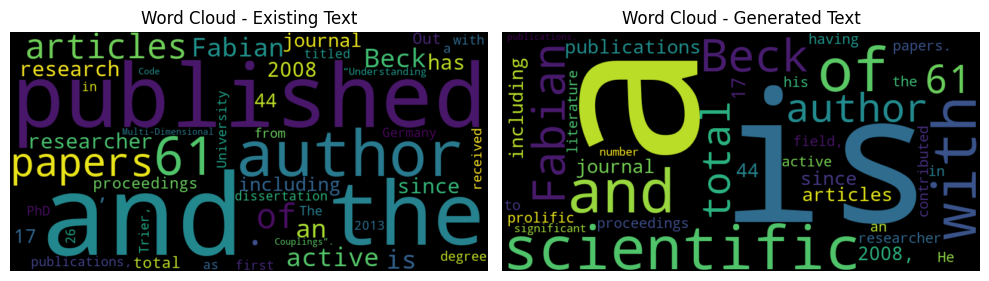

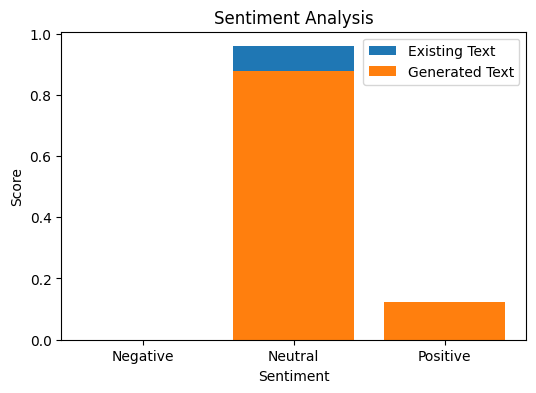

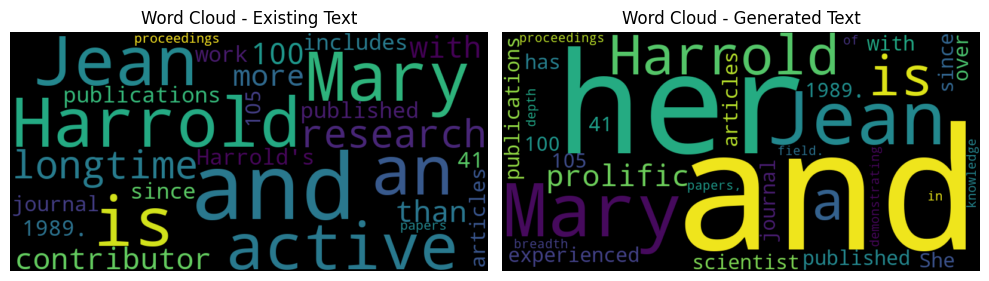

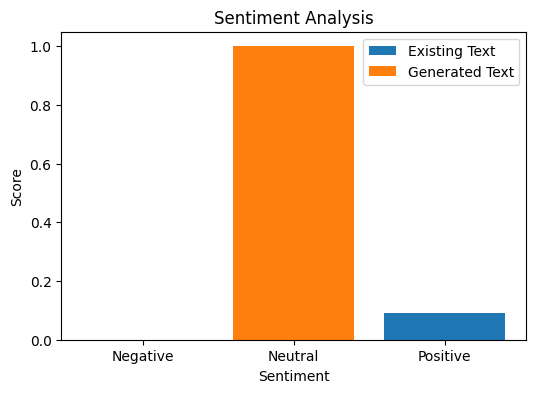

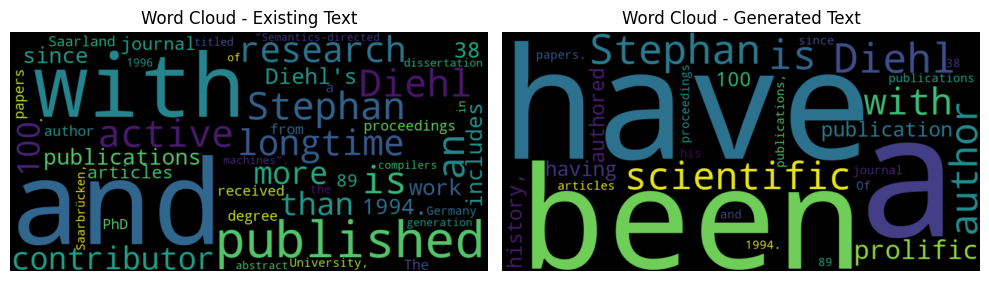

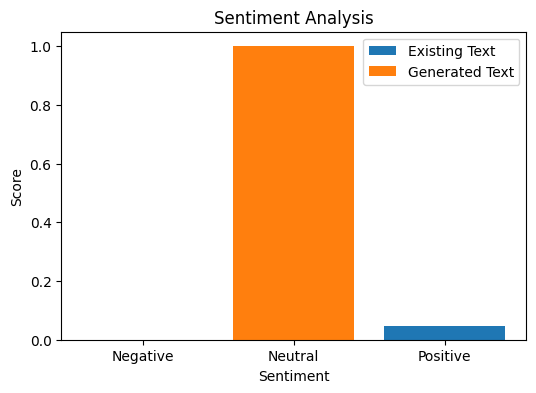

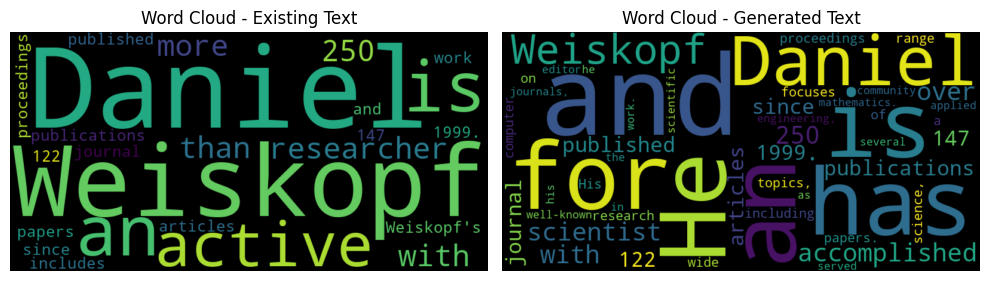

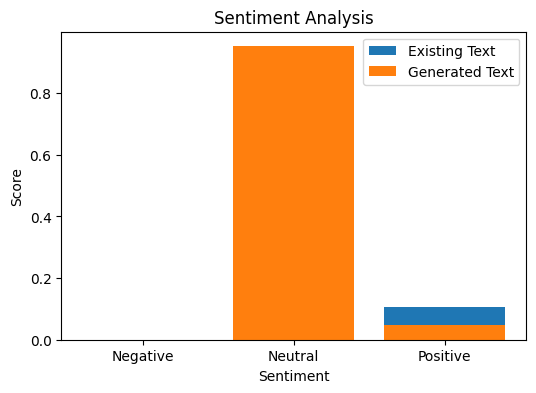

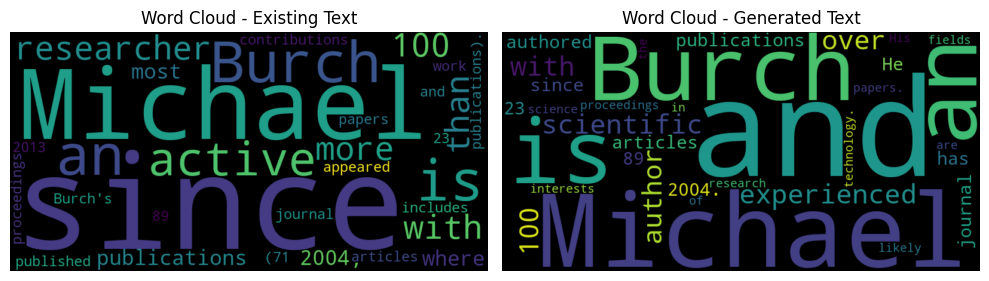

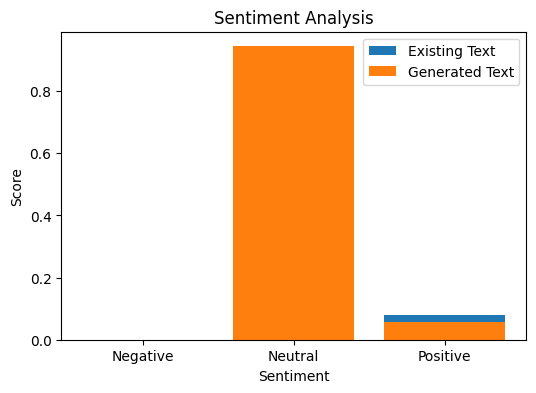

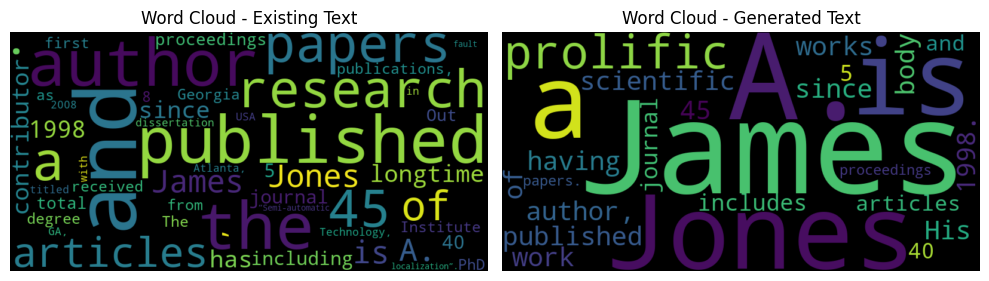

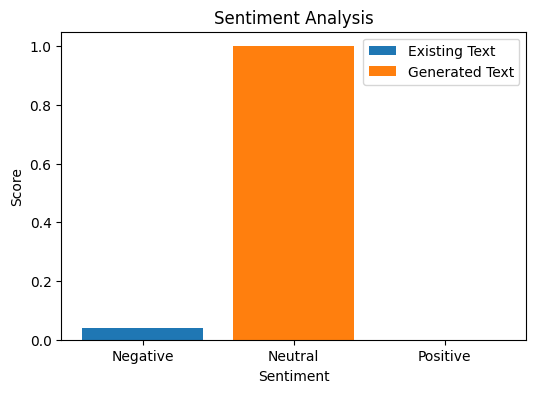

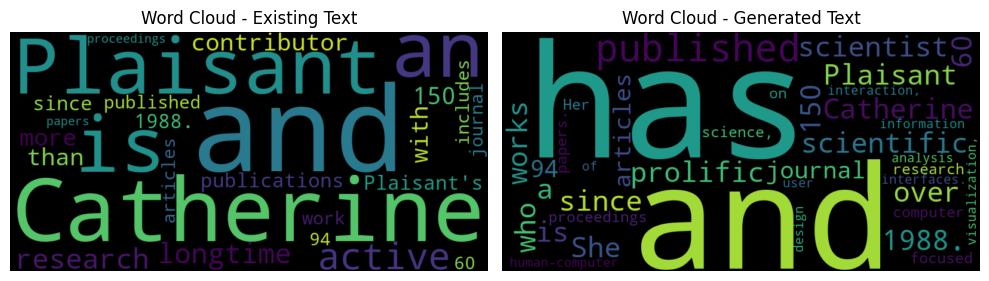

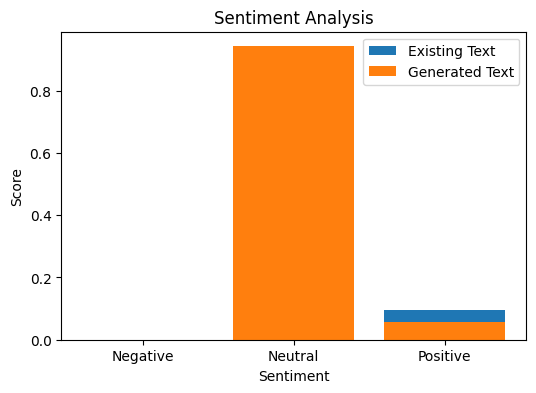

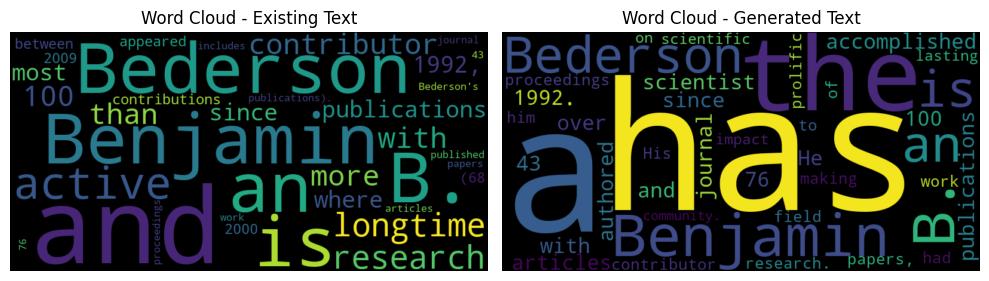

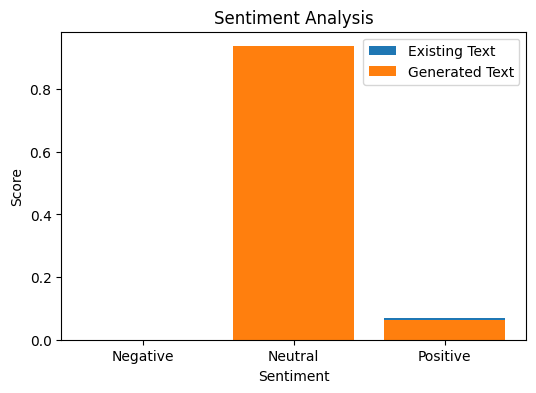

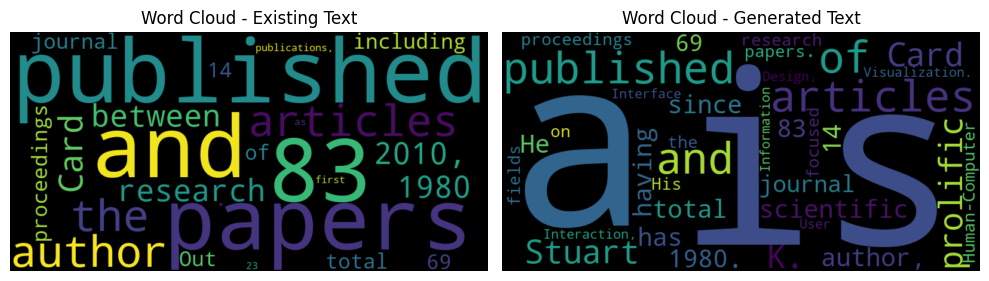

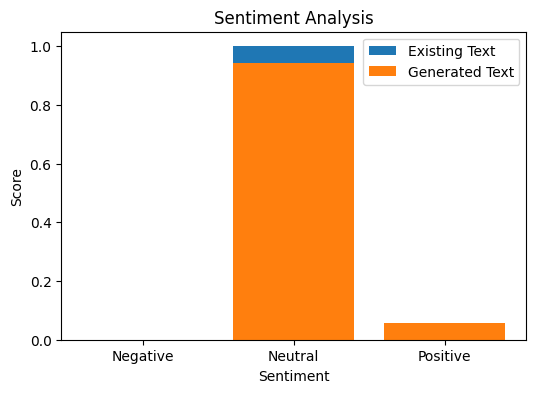

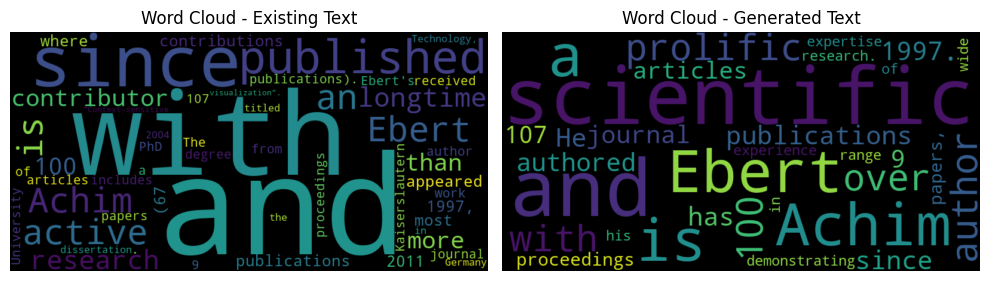

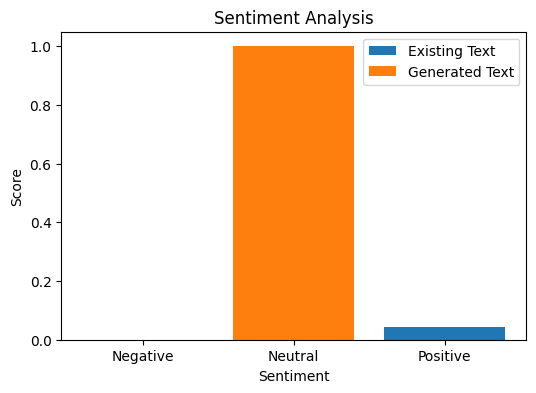

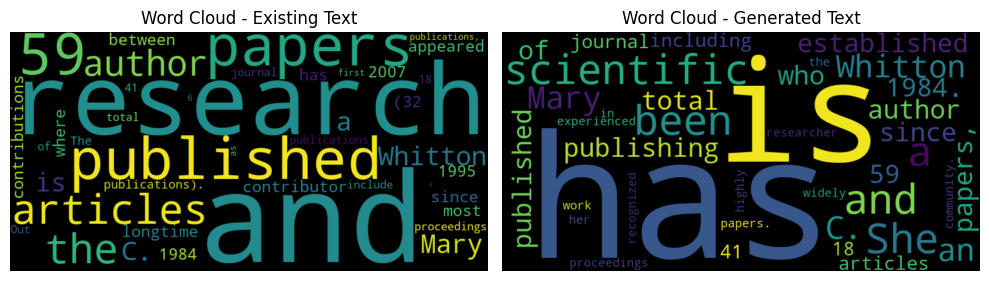

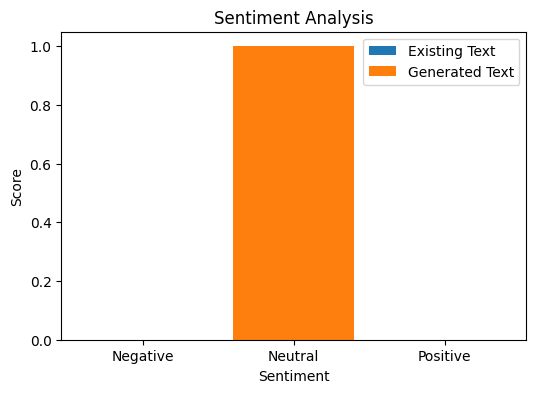

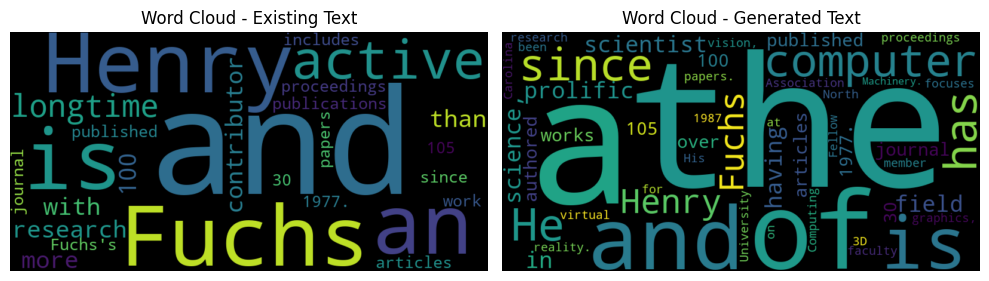

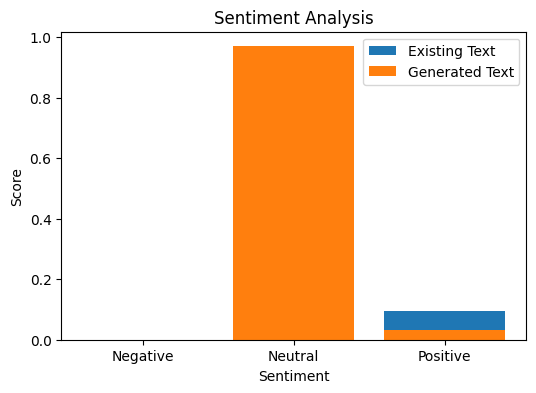

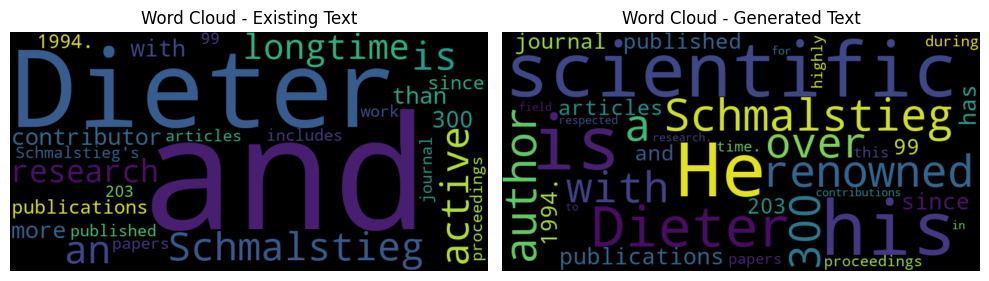

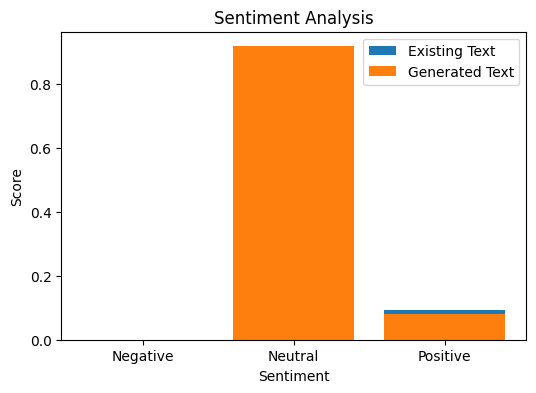

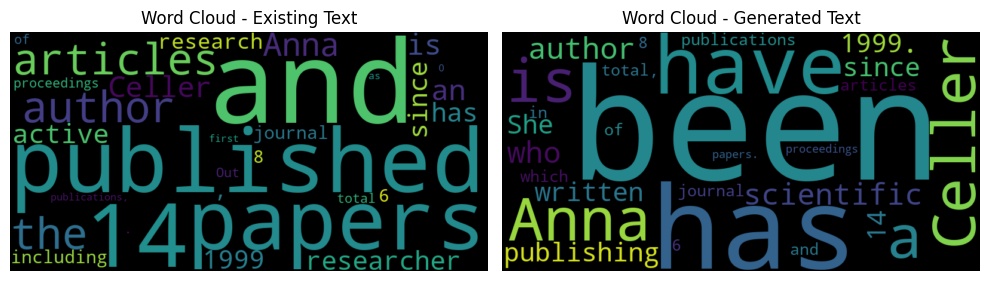

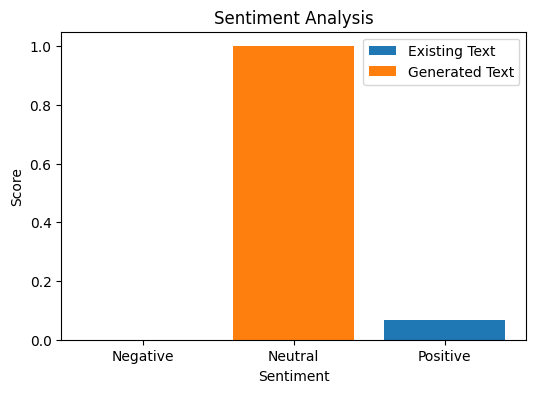

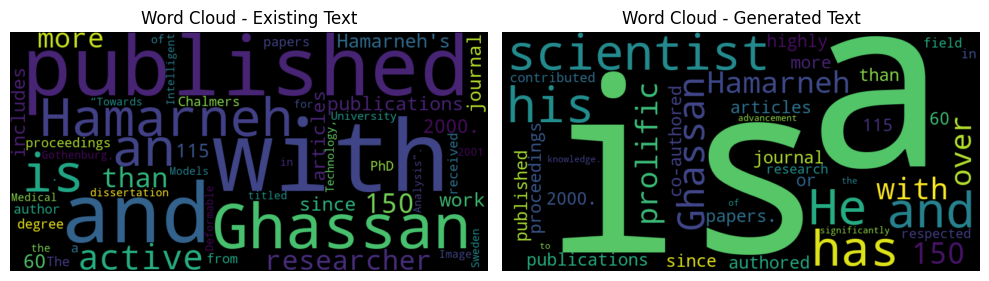

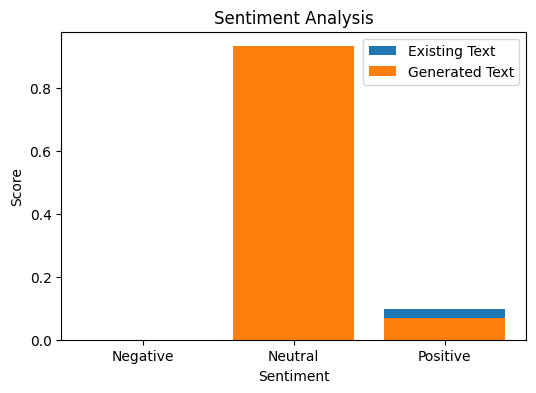

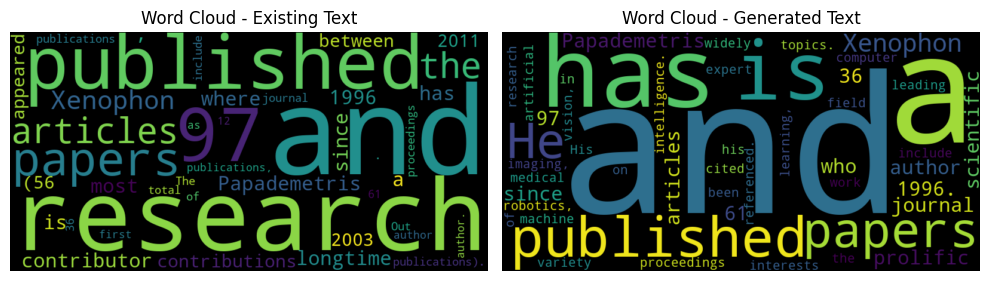

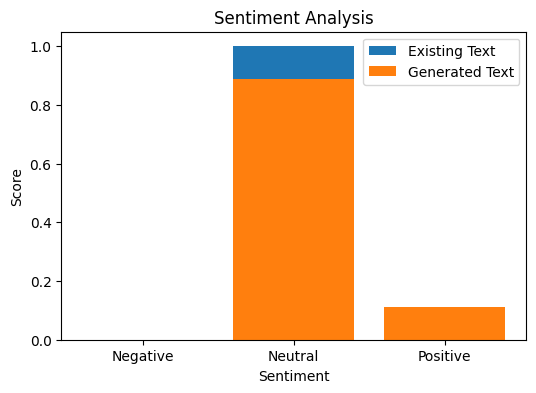

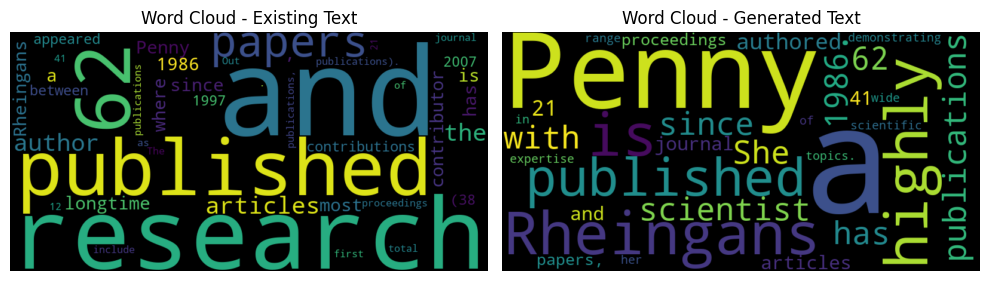

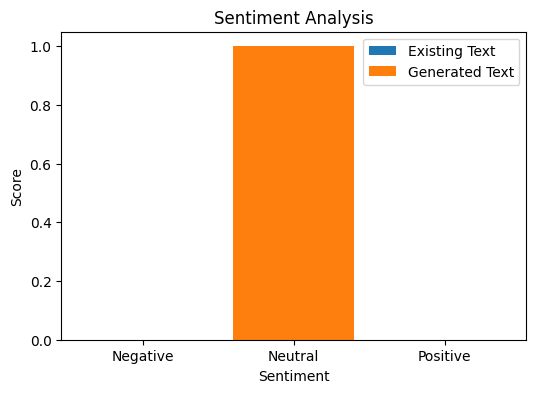

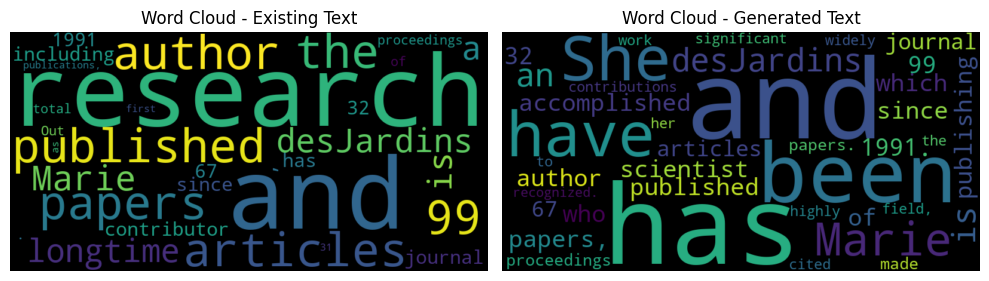

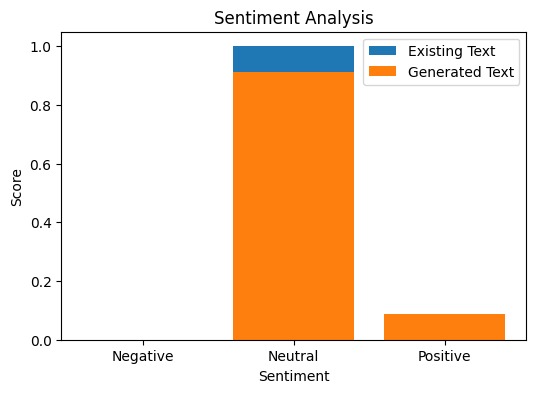

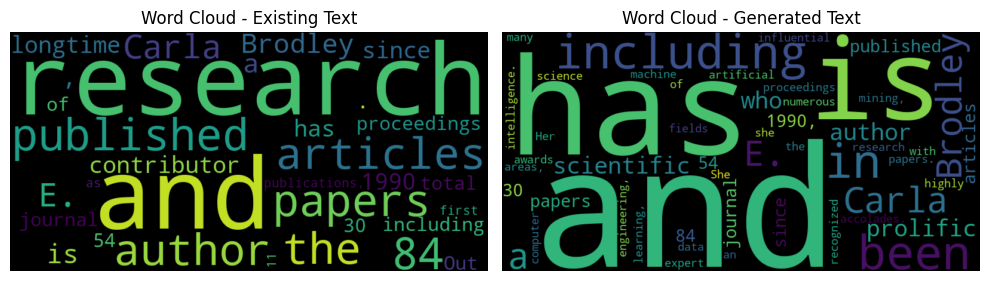

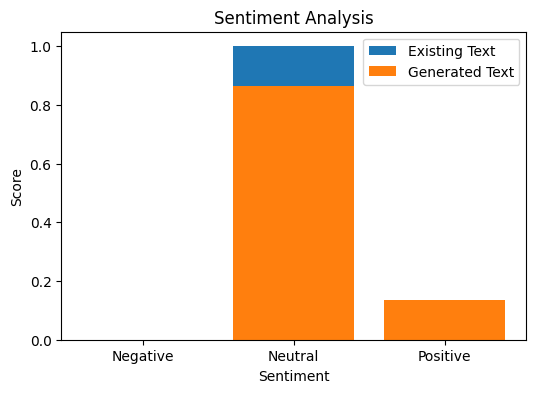

In [25]:


# Step 2: Define a function to compare texts
def compare_texts(existing_text, generated_text):
    # Tokenize the texts
    existing_tokens = existing_text.split()
    generated_tokens = generated_text.split()

    # Calculate word frequency
    existing_word_freq = Counter(existing_tokens)
    generated_word_freq = Counter(generated_tokens)

    return existing_word_freq, generated_word_freq

# Step 3: Iterate over each entry in the JSON data
for entry in data:
    existing_text = entry['existing_text']
    generated_text = entry['generated_text1']

    existing_word_freq, generated_word_freq = compare_texts(existing_text, generated_text)

    # Generate word clouds
    existing_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(existing_word_freq)
    generated_wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(generated_word_freq)

    # Plot word clouds
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(existing_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Existing Text')

    plt.subplot(1, 2, 2)
    plt.imshow(generated_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud - Generated Text')

    plt.tight_layout()
    plt.show()

    # Perform sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    existing_sentiment = analyzer.polarity_scores(existing_text)
    generated_sentiment = analyzer.polarity_scores(generated_text)

    # Visualize sentiment scores
    labels = ['Negative', 'Neutral', 'Positive']
    existing_sentiment_scores = [existing_sentiment['neg'], existing_sentiment['neu'], existing_sentiment['pos']]
    generated_sentiment_scores = [generated_sentiment['neg'], generated_sentiment['neu'], generated_sentiment['pos']]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, existing_sentiment_scores, label='Existing Text')
    plt.bar(labels, generated_sentiment_scores, label='Generated Text')
    plt.xlabel('Sentiment')
    plt.ylabel('Score')
    plt.title('Sentiment Analysis')
    plt.legend()
    plt.show()


In [61]:
from genderize import Genderize

# Function to get the gender from a given name
def get_gender(name):
    result = Genderize().get([name])
    if result[0]['gender'] is not None:
        return result[0]['gender']
    else:
        return 'unknown'

# Iterate over each entry in the JSON data
for entry in data:
    existing_text = entry['existing_text']
    generated_text = entry['generated_text2']

    # Perform gender analysis on existing text
    existing_gender = get_gender(existing_text)
    
    # Perform gender analysis on generated text
    generated_gender = get_gender(generated_text)

    # Compare the gender bias
    if existing_gender == generated_gender:
        print("No gender bias detected.")
    else:
        print("Gender bias detected.")


No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.
No gender bias detected.


In [62]:
import nltk

nltk.download('averaged_perceptron_tagger')
import json
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import json
from collections import Counter
import matplotlib.pyplot as plt





[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
#collect adjectives based on text

adjectives_per_author = {}

for author_data in data:
    author_name = author_data['name']
    generated_texts = {f'generated_text{i+1}': author_data[f'generated_text{i+1}'] for i in range(4)}

    adjectives_per_text = {}

    for text_key, generated_text in generated_texts.items():
        # Tokenize and tag the words in the generated text
        generated_words = word_tokenize(generated_text)
        generated_tagged_words = pos_tag(generated_words)

        # Collect the adjectives from the generated text
        adjectives = [word for word, pos in generated_tagged_words if pos.startswith('JJ')]

        adjectives_per_text[text_key] = adjectives

    adjectives_per_author[author_name] = adjectives_per_text

# Print the collected adjectives per author and text
for author, text_adjectives in adjectives_per_author.items():
    print(f"Author: {author}")
    for text, adjectives in text_adjectives.items():
        print(f"Text: {text}")
        print(f"Adjectives: {adjectives}")
        print()

# Save the adjectives per author in a JSON file
output_data = {'adjectives_per_author': adjectives_per_author}

with open('adjectives2.json', 'w') as output_file:
    json.dump(output_data, output_file, indent=4)

print("Adjectives per author have been saved in adjectives.json.")


Author: Ben Shneiderman
Text: generated_text1
Adjectives: ['productive', 'journal', 'human-computer', 'numerous']

Text: generated_text2
Adjectives: ['1972-present']

Text: generated_text3
Adjectives: ['journal']

Text: generated_text4
Adjectives: ['prolific', 'journal']

Author: Fabian Beck
Text: generated_text1
Adjectives: ['Fabian', 'journal', 'active', 'scientific', 'wide', 'deep']

Text: generated_text2
Adjectives: ['Frequent', '2008-present']

Text: generated_text3
Adjectives: ['Fabian', 'journal']

Text: generated_text4
Adjectives: ['Fabian', 'journal', 'proceedings']

Author: Mary Jean Harrold
Text: generated_text1
Adjectives: ['Mary', 'prolific', 'scientific', 'journal', 'important', 'scientific']

Text: generated_text2
Adjectives: ['1989-present']

Text: generated_text3
Adjectives: ['Mary', 'prolific', 'journal']

Text: generated_text4
Adjectives: ['Mary', 'journal']

Author: Stephan Diehl
Text: generated_text1
Adjectives: ['prolific', 'scientific', 'journal', 'influential']


Exaggerated Adjectives:
Author: Ben Shneiderman, Text: generated_text4, Adjective: prolific
Author: Mary Jean Harrold, Text: generated_text1, Adjective: prolific
Author: Mary Jean Harrold, Text: generated_text3, Adjective: prolific
Author: Stephan Diehl, Text: generated_text1, Adjective: prolific
Author: Stephan Diehl, Text: generated_text3, Adjective: prolific
Author: Stephan Diehl, Text: generated_text4, Adjective: prolific
Author: Daniel Weiskopf, Text: generated_text1, Adjective: prolific
Author: James A. Jones, Text: generated_text1, Adjective: prolific
Author: James A. Jones, Text: generated_text4, Adjective: prolific
Author: Benjamin B. Bederson, Text: generated_text1, Adjective: prolific
Author: Achim Ebert, Text: generated_text2, Adjective: prolific
Author: Mary C. Whitton, Text: generated_text1, Adjective: prolific
Author: Henry Fuchs, Text: generated_text1, Adjective: esteemed
Author: Ghassan Hamarneh, Text: generated_text1, Adjective: prolific
Author: Ghassan Hamarneh, Text

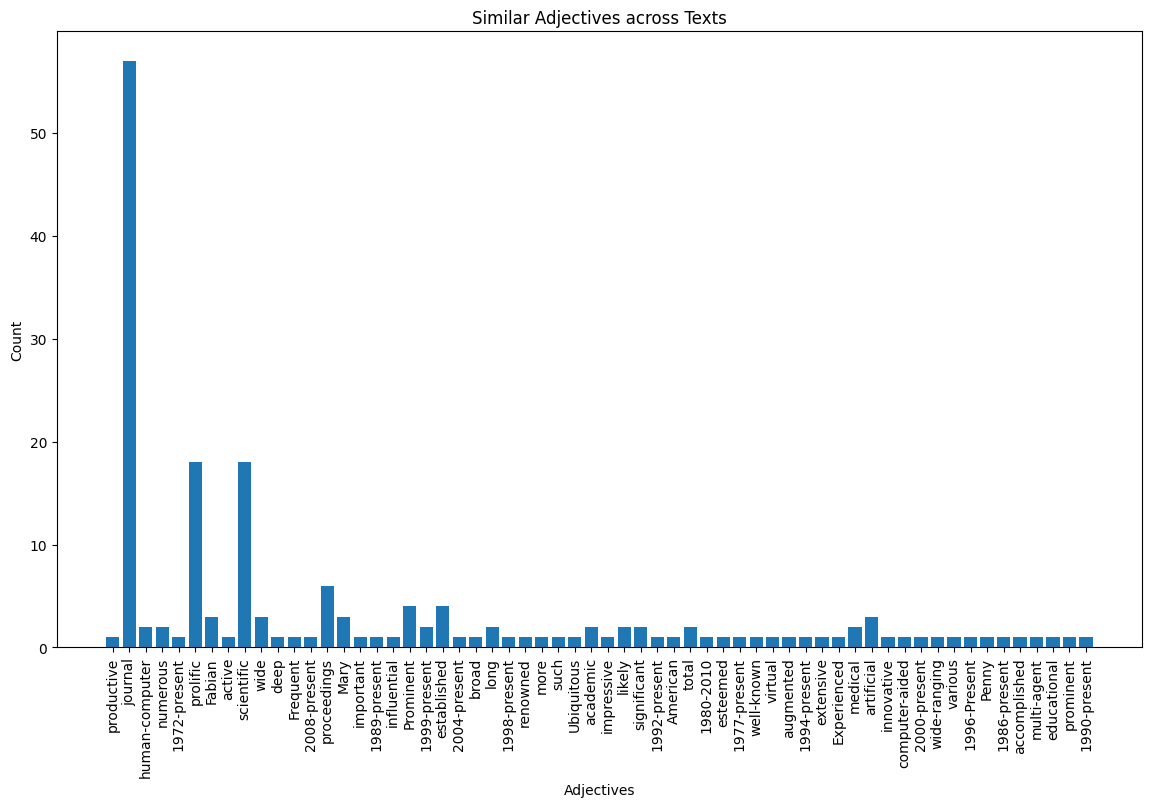

In [55]:
# Load the data from the JSON file
with open('adjectives2.json') as file:
    data = json.load(file)

adjectives_per_author = data['adjectives_per_author']

# Identify exaggerated adjectives and calculate similarity
exaggerated_adjectives = []
similarity_counts = Counter()

for author_name, author_data in adjectives_per_author.items():
    for text_key, adjectives in author_data.items():
        if adjectives:
            # Check for exaggerated adjectives
            for adjective in adjectives:
                if adjective.lower() in ['prolific', 'esteemed']:
                    exaggerated_adjectives.append((author_name, text_key, adjective))

            # Update similarity counts
            similarity_counts.update(adjectives)

# Print exaggerated adjectives
if exaggerated_adjectives:
    print("Exaggerated Adjectives:")
    for author_name, text_key, adjective in exaggerated_adjectives:
        print(f"Author: {author_name}, Text: {text_key}, Adjective: {adjective}")
else:
    print("No exaggerated adjectives found.")

# Visualize similarity counts
adjectives = list(similarity_counts.keys())
counts = list(similarity_counts.values())
plt.figure(figsize=(14, 8))
plt.bar(adjectives, counts)
plt.xlabel('Adjectives')
plt.ylabel('Count')
plt.title('Similar Adjectives across Texts')
plt.xticks(rotation=90)
plt.show()


Exaggerated Adjectives:
Author: Ben Shneiderman, Text: generated_text4, Adjective: prolific
Author: Mary Jean Harrold, Text: generated_text1, Adjective: prolific
Author: Mary Jean Harrold, Text: generated_text3, Adjective: prolific
Author: Stephan Diehl, Text: generated_text1, Adjective: prolific
Author: Stephan Diehl, Text: generated_text3, Adjective: prolific
Author: Stephan Diehl, Text: generated_text4, Adjective: prolific
Author: Daniel Weiskopf, Text: generated_text1, Adjective: prolific
Author: James A. Jones, Text: generated_text1, Adjective: prolific
Author: James A. Jones, Text: generated_text4, Adjective: prolific
Author: Benjamin B. Bederson, Text: generated_text1, Adjective: prolific
Author: Achim Ebert, Text: generated_text2, Adjective: prolific
Author: Mary C. Whitton, Text: generated_text1, Adjective: prolific
Author: Henry Fuchs, Text: generated_text1, Adjective: esteemed
Author: Ghassan Hamarneh, Text: generated_text1, Adjective: prolific
Author: Ghassan Hamarneh, Text

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (19,).

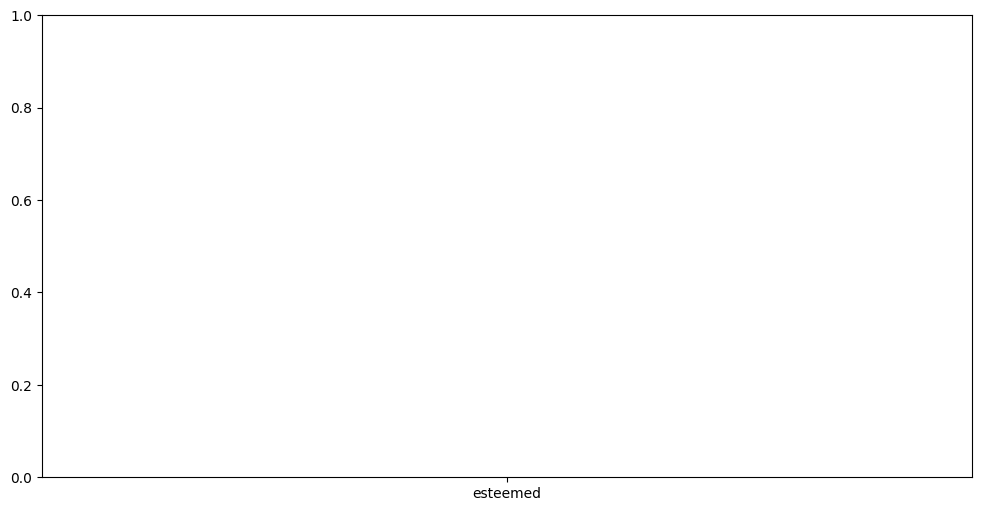

In [64]:
# Load the data from the JSON file
with open('adjectives2.json') as file:
    data = json.load(file)

adjectives_per_author = data['adjectives_per_author']

# Identify exaggerated adjectives and count their occurrences
exaggerated_adjectives = []
exaggerated_counts = Counter()

for author_name, author_data in adjectives_per_author.items():
    for text_key, adjectives in author_data.items():
        if adjectives:
            for adjective in adjectives:
                if adjective.lower() in ['prolific', 'esteemed']:
                    exaggerated_adjectives.append((author_name, text_key, adjective))
                    exaggerated_counts[(author_name, text_key, adjective)] += 1

# Print exaggerated adjectives and their counts
if exaggerated_adjectives:
    print("Exaggerated Adjectives:")
    for author_name, text_key, adjective in exaggerated_adjectives:
        print(f"Author: {author_name}, Text: {text_key}, Adjective: {adjective}")
else:
    print("No exaggerated adjectives found.")

# Print counts of exaggerated adjectives
if exaggerated_counts:
    print("\nExaggerated Adjective Counts:")
    for (author_name, text_key, adjective), count in exaggerated_counts.items():
        print(f"Author: {author_name}, Text: {text_key}, Adjective: {adjective}, Count: {count}")
else:
    print("No exaggerated adjectives found.")

# Visualize counts of exaggerated adjectives
if exaggerated_counts:
    adjectives = list(set([adj for _, _, adj in exaggerated_adjectives]))
    counts = [exaggerated_counts[(author, text, adj)] for author, text, adj in exaggerated_adjectives]
    plt.figure(figsize=(12, 6))
    plt.bar(adjectives, counts)
    plt.xlabel('Exaggerated Adjectives')
    plt.ylabel('Count')
    plt.title('Counts of Exaggerated Adjectives across Texts')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No exaggerated adjectives found.")
